<a href="https://colab.research.google.com/github/Ronokhasan8781/CNN-Code/blob/main/Gastric_99_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

ronokhasan_gastric_path = kagglehub.dataset_download('ronokhasan/gastric')

print('Data source import complete.')


In [ ]:
# For Data Processing
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance

# For ML Models
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Miscellaneous
from tqdm import tqdm
import os
import random

In [ ]:
import os
from sklearn.utils import shuffle

train_dir = '/kaggle/input/gastric/train'
test_dir = '/kaggle/input/gastric/test'

train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    label_dir = os.path.join(train_dir, label)  # Use os.path.join for proper path handling
    if os.path.isdir(label_dir):  # Ensure it's a directory
        for image in os.listdir(label_dir):
            train_paths.append(os.path.join(label_dir, image))  # Properly join the path
            train_labels.append(label)

# Shuffle paths and labels
train_paths, train_labels = shuffle(train_paths, train_labels)


In [ ]:
plt.figure(figsize=(14,6))
colors = ['#F6F7C1', '#BEF0CB', '#D1FFF3', '#C1AEFC']
plt.rcParams.update({'font.size': 20})
plt.pie([len([x for x in train_labels if x=='0_normal']),
         len([x for x in train_labels if x=='1_ulcerative_colitis']),
         len([x for x in train_labels if x=='2_polyps']),
         len([x for x in train_labels if x=='3_esophagitis'])],
        labels=['0_normal','1_ulcerative_colitis', '2_polyps', '3_esophagitis'],
        colors=colors, autopct='%.1f%%', explode=(0.015,0.015,0.015,0.015),
        startangle=30);

NameError: name 'plt' is not defined

In [ ]:
import os
from sklearn.utils import shuffle  # Ensure this import exists

test_paths = []
test_labels = []

# Ensure the directory path ends with a slash
if not test_dir.endswith('/'):
    test_dir += '/'

# Iterate through subdirectories
for label in os.listdir(test_dir):
    label_dir = os.path.join(test_dir, label)  # Create full path for label directory

    # Check if the label_dir exists and is a directory
    if os.path.isdir(label_dir):
        for image in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image)  # Create full path for the image
            test_paths.append(image_path)
            test_labels.append(label)

# Shuffle the paths and labels
test_paths, test_labels = shuffle(test_paths, test_labels)


In [ ]:
plt.figure(figsize=(14,6))
colors = ['#BEF0CB', '#C1AEFC']
plt.rcParams.update({'font.size': 20})
plt.pie([len(train_labels), len(test_labels)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.05,0),
        startangle=30);

In [ ]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image = np.array(image)/255.0
    return image

In [ ]:
IMAGE_SIZE = 128

def open_images(paths):
    '''
    Given a list of paths to images, this function returns the images as arrays (after augmenting them)
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE,IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

images = open_images(train_paths[50:59])
labels = train_labels[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 20})
plt.show()

In [ ]:
unique_labels = os.listdir(train_dir)

def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

In [ ]:
base_model = VGG16(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet')
# Set all layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False
# Set the last vgg block to trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

model = Sequential()
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels), activation='softmax'))

In [ ]:
model.summary()

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

In [ ]:
batch_size = 25
steps = int(len(train_paths)/batch_size)
epochs = 100
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/100


I0000 00:00:1733593497.609693      95 service.cc:145] XLA service 0x7ac94c0024f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733593497.609767      95 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733593497.609772      95 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  2/208 ━━━━━━━━━━━━━━━━━━━━ 14s 71ms/step - loss: 1.6868 - sparse_categorical_accuracy: 0.3900 

I0000 00:00:1733593506.726374      95 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


208/208 ━━━━━━━━━━━━━━━━━━━━ 71s 292ms/step - loss: 0.4443 - sparse_categorical_accuracy: 0.8230
Epoch 2/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 37s 178ms/step - loss: 0.1110 - sparse_categorical_accuracy: 0.9597
Epoch 3/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 37s 177ms/step - loss: 0.0466 - sparse_categorical_accuracy: 0.9846
Epoch 4/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 37s 176ms/step - loss: 0.0326 - sparse_categorical_accuracy: 0.9874
Epoch 5/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 37s 178ms/step - loss: 0.0243 - sparse_categorical_accuracy: 0.9917
Epoch 6/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 37s 176ms/step - loss: 0.0231 - sparse_categorical_accuracy: 0.9929
Epoch 7/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 37s 177ms/step - loss: 0.0182 - sparse_categorical_accuracy: 0.9934
Epoch 8/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 37s 176ms/step - loss: 0.0226 - sparse_categorical_accuracy: 0.9933
Epoch 9/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 37s 177ms/step - loss: 0.0019 - sparse_categorical_accuracy: 1.0000
Epoch 10/100
208/208 ━━━━━━━━━━

In [ ]:
#Federated Learning Based transfer Learning enabled VGG-16 Model
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the number of clients and the number of training rounds
NUM_CLIENTS = 10
NUM_ROUNDS = 3


# Define the clients and their data
clients = []
for i in range(NUM_CLIENTS):
    client_data = train_paths[i * (len(train_paths) // NUM_CLIENTS):(i + 1) * (len(train_paths) // NUM_CLIENTS)]
    client_labels = train_labels[i * (len(train_labels) // NUM_CLIENTS):(i + 1) * (len(train_labels) // NUM_CLIENTS)]
    clients.append((client_data, client_labels))

# Federated learning loop
for round_num in range(NUM_ROUNDS):

    # Select clients
    selected_client_indices = np.random.choice(len(clients), size=int(NUM_CLIENTS * 0.5), replace=False)
    selected_clients = [clients[i] for i in selected_client_indices]

    # Transmit the global model to the selected clients
    for client in selected_clients:
        client_model = tf.keras.models.clone_model(model)
        client_model.set_weights(model.get_weights())

        # Compile the client model
        client_model.compile(optimizer=Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy'])

        steps_per_epoch = int(len(client[0]) / 20)


        client_model.fit(datagen(client[0],client[1], batch_size=batch_size, epochs=epochs),
                         epochs=5, steps_per_epoch=steps_per_epoch)

        # Train locally
        steps_per_epoch = int(len(client[0]) / 20)

        # Aggregate the model
        new_weights = []
        for layer_index in range(len(model.get_weights())):
            new_layer_weights = np.mean([client_model.get_weights()[layer_index], model.get_weights()[layer_index]], axis=0)
            new_weights.append(new_layer_weights)
        model.set_weights(new_weights)


batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

#     # Evaluate the global model
#     test_loss, test_acc = model.evaluate(test_paths, test_labels,)
#     print('Round {}: Test accuracy = {}'.format(round_num, test_acc))

# # Fine-tune the model
# model.fit(test_paths, test_labels, epochs=1, batch_size=32)

# Deploy the model
model.save('my_model.h5')

Epoch 1/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 17s 504ms/step - loss: 8.1128e-10 - sparse_categorical_accuracy: 1.0000
Epoch 2/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 177ms/step - loss: 2.5241e-09 - sparse_categorical_accuracy: 1.0000
Epoch 3/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - loss: 1.7548e-09 - sparse_categorical_accuracy: 1.0000
Epoch 4/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - loss: 9.5170e-10 - sparse_categorical_accuracy: 1.0000
Epoch 5/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 172ms/step - loss: 6.3913e-08 - sparse_categorical_accuracy: 1.0000
Epoch 1/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 269ms/step - loss: 7.5099e-09 - sparse_categorical_accuracy: 1.0000
Epoch 2/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 167ms/step - loss: 2.5409e-10 - sparse_categorical_accuracy: 1.0000
Epoch 3/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 175ms/step - loss: 1.7100e-09 - sparse_categorical_accuracy: 1.0000
Epoch 4/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 173ms/step - loss: 9.1982e-10 - sparse_categorical_accuracy: 1.0000
Epoch 5/5
26/26 ━━━━━━━━━━

  0%|          | 0/25 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


  4%|▍         | 1/25 [00:09<03:58,  9.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  8%|▊         | 2/25 [00:10<01:41,  4.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 12%|█▏        | 3/25 [00:10<00:57,  2.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 16%|█▌        | 4/25 [00:11<00:38,  1.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 20%|██        | 5/25 [00:12<00:27,  1.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 24%|██▍       | 6/25 [00:12<00:20,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 28%|██▊       | 7/25 [00:13<00:16,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 32%|███▏      | 8/25 [00:13<00:13,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 36%|███▌      | 9/25 [00:14<00:11,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 40%|████      | 10/25 [00:14<00:09,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 44%|████▍     | 11/25 [00:15<00:08,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 48%|████▊     | 12/25 [00:15<00:07,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 52%|█████▏    | 13/25 [00:16<00:06,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 56%|█████▌    | 14/25 [00:16<00:05,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 60%|██████    | 15/25 [00:17<00:05,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 64%|██████▍   | 16/25 [00:17<00:04,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 68%|██████▊   | 17/25 [00:18<00:04,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 72%|███████▏  | 18/25 [00:18<00:03,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 76%|███████▌  | 19/25 [00:19<00:03,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 80%|████████  | 20/25 [00:19<00:02,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 84%|████████▍ | 21/25 [00:20<00:02,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 88%|████████▊ | 22/25 [00:20<00:01,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 92%|█████████▏| 23/25 [00:21<00:01,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 96%|█████████▌| 24/25 [00:22<00:00,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


100%|██████████| 25/25 [00:22<00:00,  1.11it/s]


In [ ]:
print(classification_report(y_true, y_pred))

                      precision    recall  f1-score   support

            0_normal       1.00      1.00      1.00       200
1_ulcerative_colitis       0.96      0.99      0.98       200
            2_polyps       0.99      0.96      0.97       200
       3_esophagitis       1.00      1.00      1.00       200

            accuracy                           0.99       800
           macro avg       0.99      0.99      0.99       800
        weighted avg       0.99      0.99      0.99       800



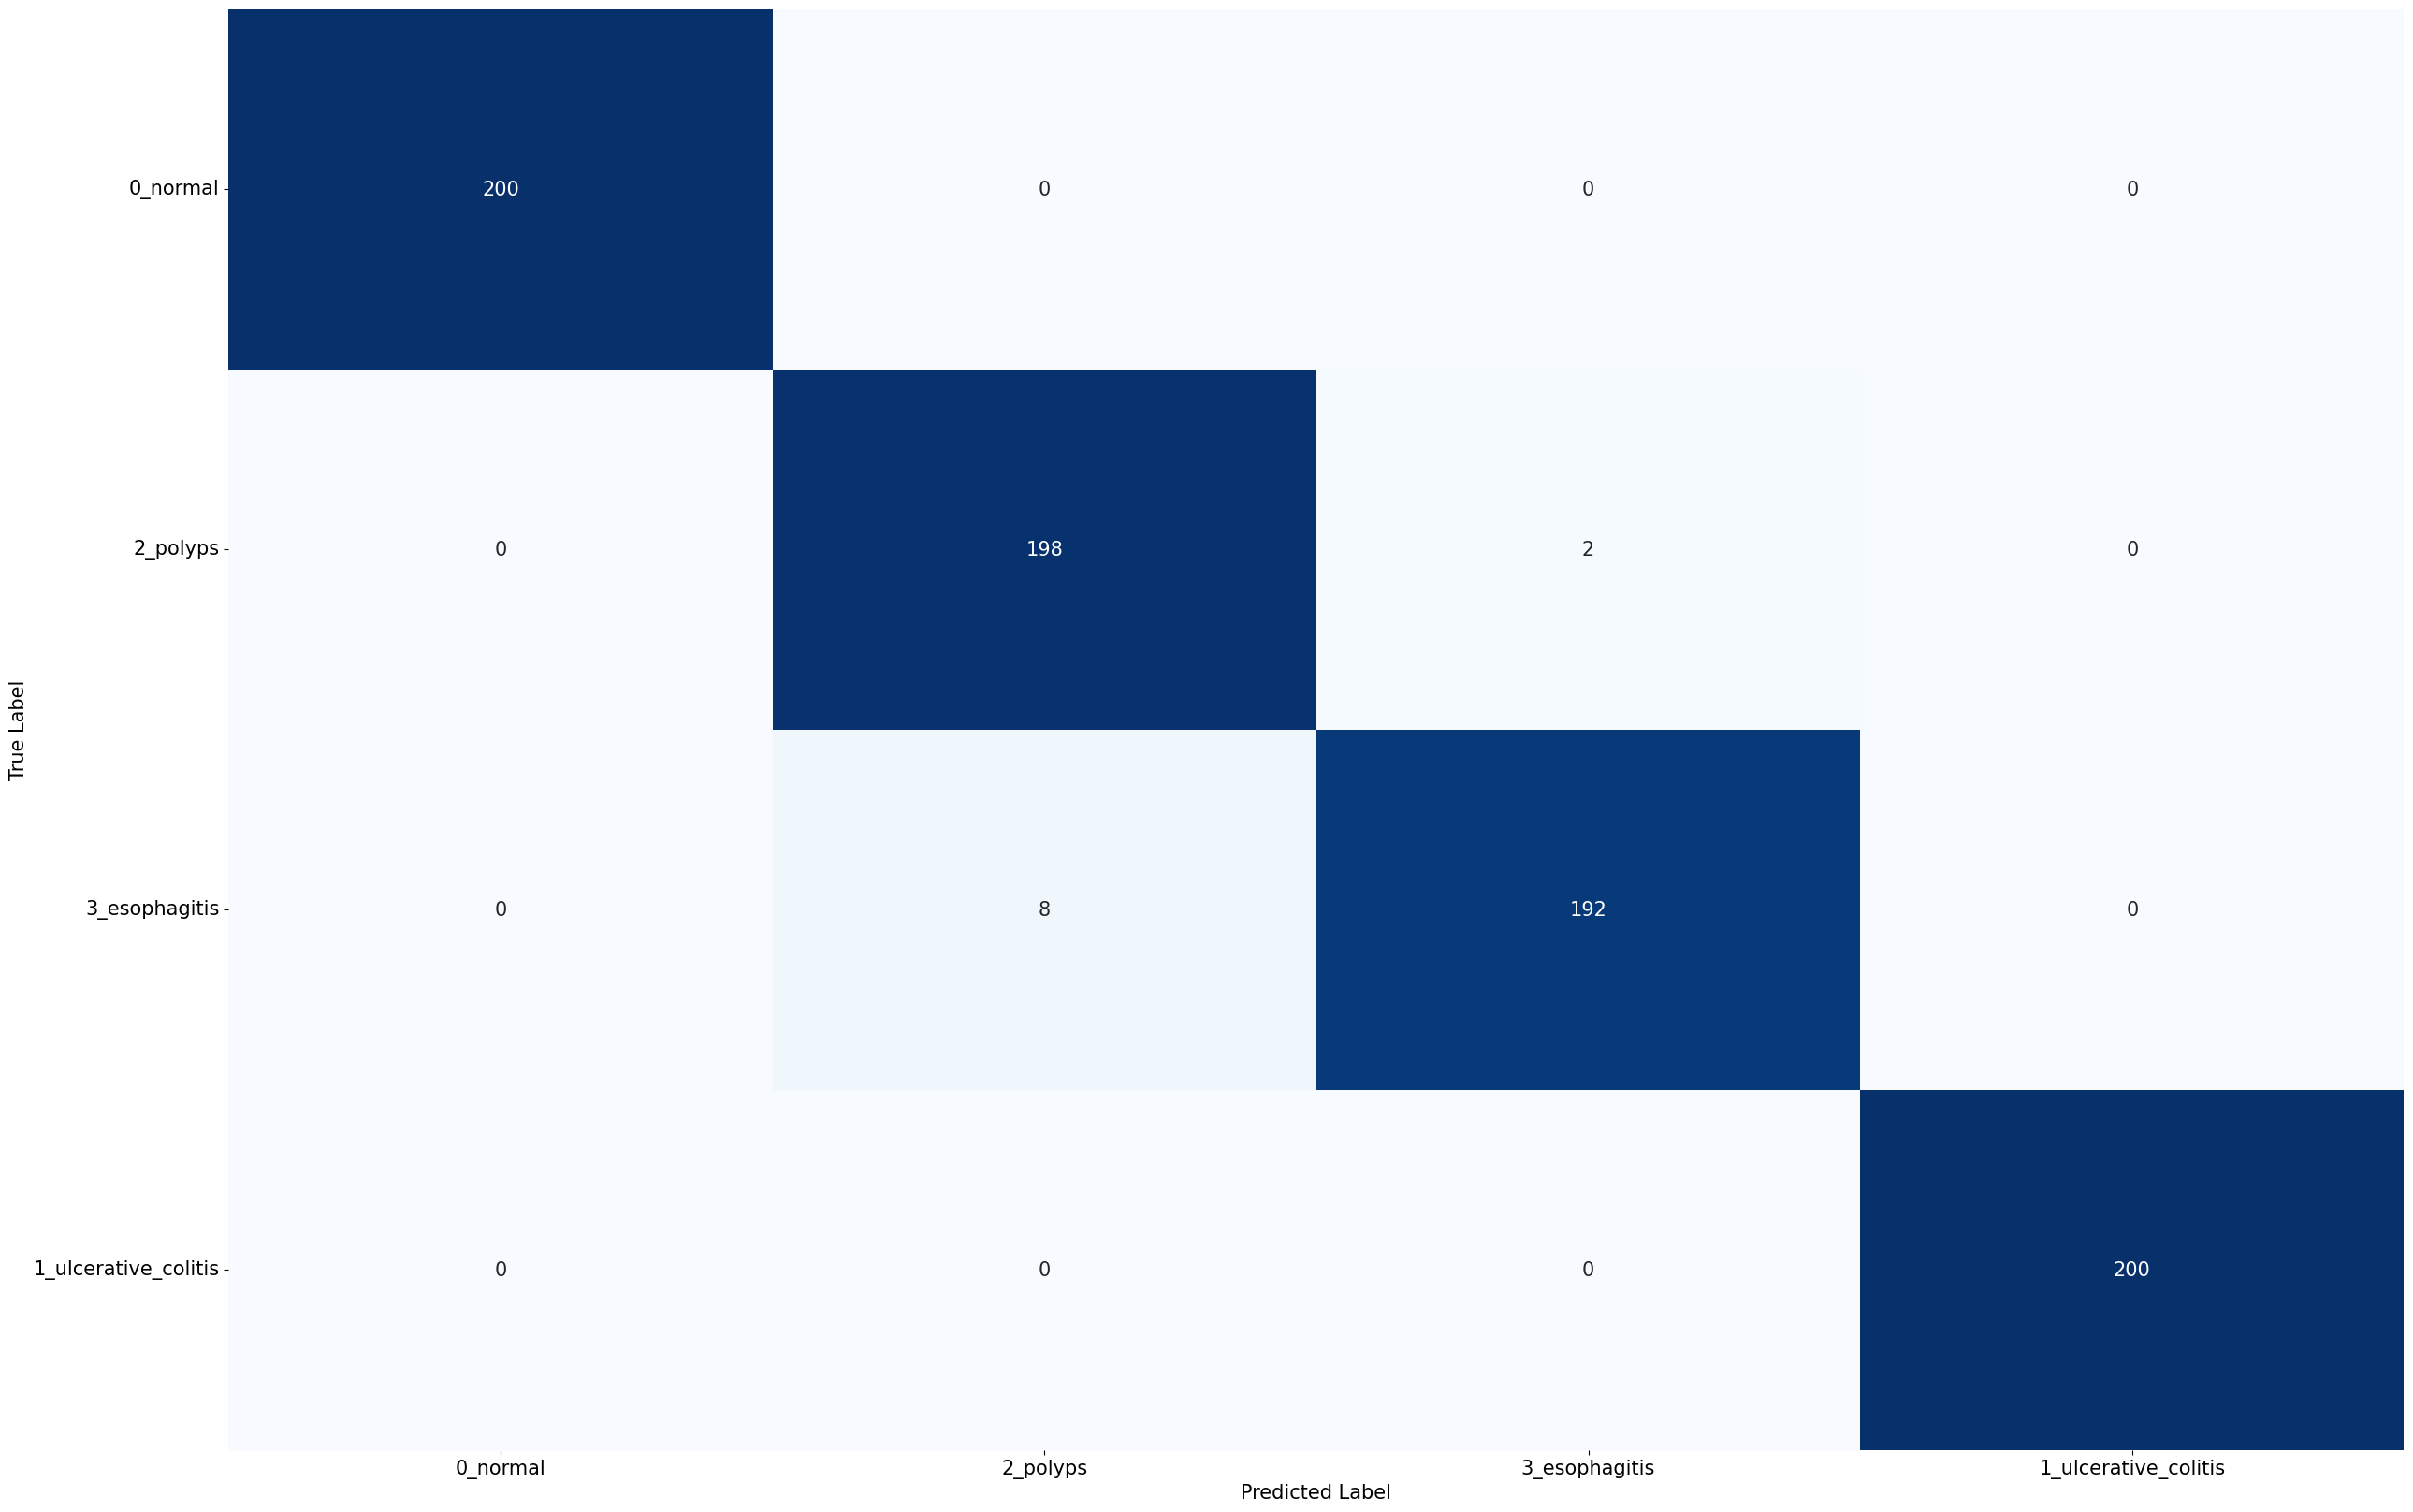

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np




cm = confusion_matrix(y_true, y_pred)

# Define the font size
font_size = 15

# Plot the confusion matrix
plt.figure(figsize=(30,20))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=unique_labels, yticklabels=unique_labels, annot_kws={"fontsize": font_size}, cbar=False)
plt.xlabel("Predicted Label", fontsize=font_size)
plt.ylabel("True Label", fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size, rotation=0)
plt.savefig('confution_matrix.jpg', dpi=500 )
plt.show()

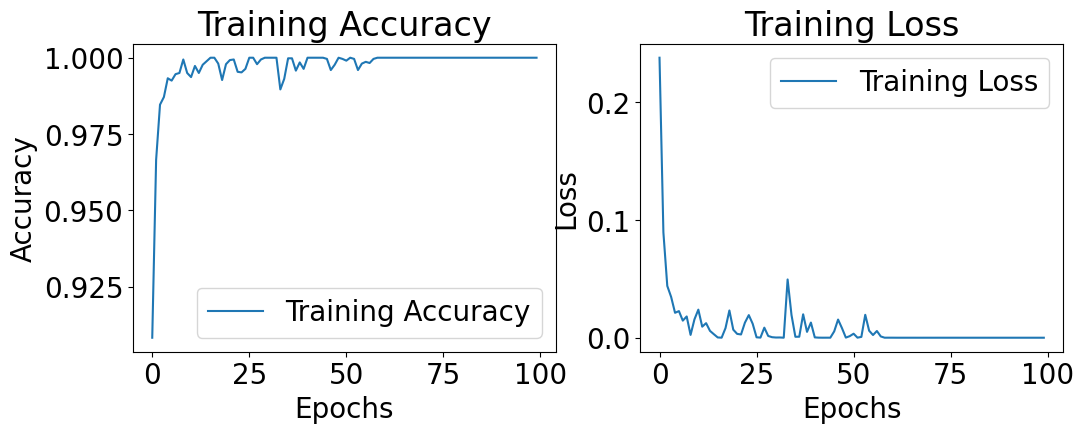

In [ ]:
def plot_training_history(history):
    acc = history.history['sparse_categorical_accuracy']
    loss = history.history['loss']

    # Plot Accuracy
    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    plt.show()

# Usage: Pass the training history object
plot_training_history(history)


In [ ]:
!pip install shap

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


In [ ]:
from lime import lime_image
import shap


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━

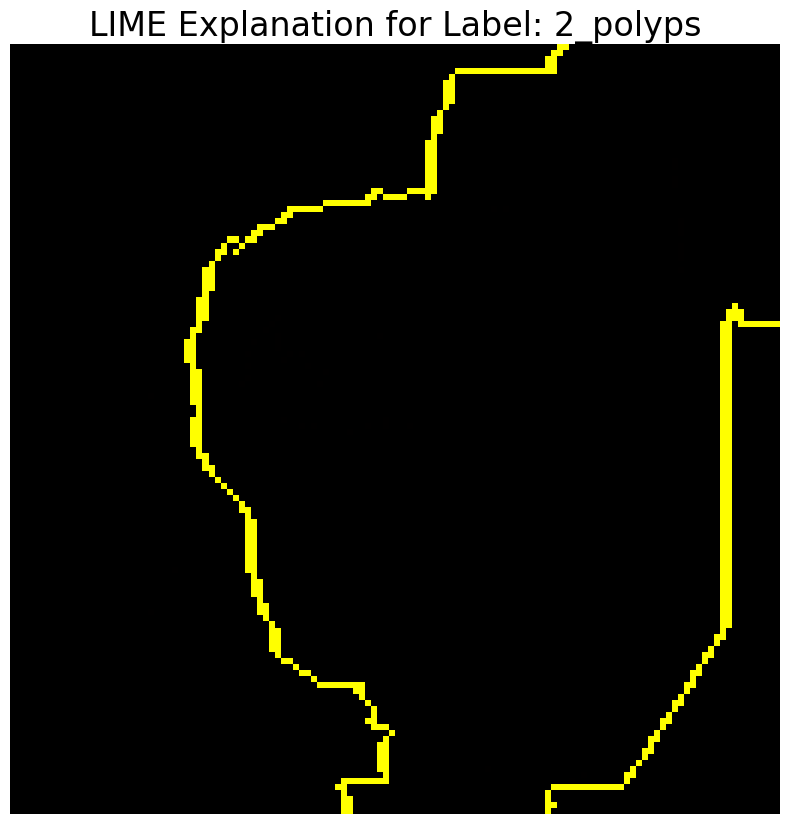

In [ ]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

def explain_with_lime(model, image, label):
    # Create a LIME explainer
    explainer = lime_image.LimeImageExplainer()

    # Explain the prediction
    explanation = explainer.explain_instance(
        image,
        model.predict,
        top_labels=1,
        hide_color=0,
        num_samples=1000
    )

    # Get the top label from the explanation
    top_label = explanation.top_labels[0]

    # Get the image and mask using a different method
    temp, mask = explanation.get_image_and_mask(
        top_label,
        positive_only=True,
        num_features=10,
        hide_rest=False
    )

    # Display the explanation
    plt.figure(figsize=(10, 10))
    plt.imshow(mark_boundaries(temp / 255.0, mask))
    plt.title(f"LIME Explanation for Label: {label}")
    plt.axis('off')
    plt.show()

# Example of using LIME on a test image
sample_image_path = test_paths[0]  # Choose a sample image path from your test set
sample_image = load_img(sample_image_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
sample_image_array = np.array(sample_image) / 255.0

# Get the predicted label for the sample image
predicted_label = np.argmax(model.predict(sample_image_array[np.newaxis, ...]), axis=-1)
explain_with_lime(model, sample_image_array, decode_label(predicted_label)[0])


NameError: name 'X_test' is not defined

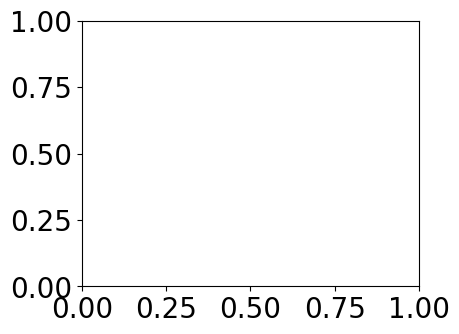

In [ ]:
# Assuming y_true holds the true labels for your test dataset
plt.figure(figsize=(20, 20))
for i in range(20):
    plt.subplot(5, 4, i + 1)
    plt.imshow(X_test[i])
    plt.title(f"Truth: {y_true[i]}\nPredicted: {y_pred[i]}")
    plt.axis('off')
plt.show()
